<a href="https://colab.research.google.com/github/shkwo-n/Leather-Anomaly-Detection-CV/blob/main/MVTEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn
import torchvision
from torchvision import models

import torchvision.utils
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from torchsummary import summary

import torch.nn.functional as F
import torch.optim as optim
import time
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Custom Dataset 만들기

#### Train dataset

In [3]:
root_dir="/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/"

train_file_list = glob.glob(root_dir + "*")

train_data = []

for class_path in train_file_list:
    class_name = class_path.split("/")[-1] # extract the class name, e.g.
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    for img_path in glob.glob(class_path + "/*.png"):
        # Check for problematic images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue
        train_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(len(train_data))

245


In [4]:
train_data[0]

['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png',
 'good']

(1024, 1024)

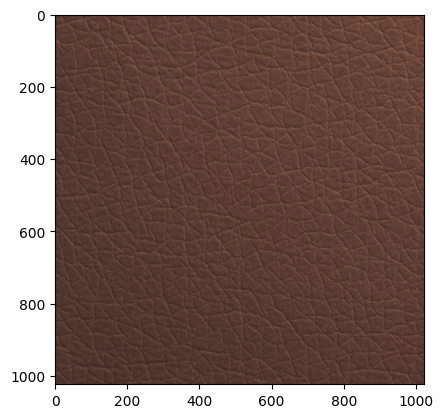

In [5]:
from PIL import Image

img = Image.open('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png')
plt.imshow(img)
img.size

In [6]:
img = cv2.imread('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png', cv2.IMREAD_COLOR)
img.shape

(1024, 1024, 3)

#### Test dataset

In [7]:
root_dir = "/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/"

# Retrieve the list of ALL folders and files inside the base folder
test_file_list = glob.glob(root_dir + "*")

test_normal = []
test_anomaly = []
# Create a list that would contain the paths to all the images in the dataset
for class_path in test_file_list:
    class_name = class_path.split("/")[-1] # extract the class name, e.g.
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    for img_path in glob.glob(class_path + "/*.png"):
        # Check for problematic images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue
        if class_name == "good":
            test_normal.append([img_path, class_name])
        else:
            test_anomaly.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(len(test_normal)+len(test_anomaly))

124


In [8]:
class CustomData(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        # Dictionary containing mapping between string and number (class label)
        self.class_map = {"good":0,"color" : 1, "cut": 1,"fold":1, "glue":1, "poke":1}
        # Set image dimensions
        self.img_dim = (1024, 1024)
        # Perform any transformations
        self.transform= transform

    def __len__(self):
        return len(self.data)

    # This function is called when an element of this class is accessed via dataset[index]
    def __getitem__(self, index):
        # Get image path and class name
        img_path, class_name = self.data[index] # tuple from __init__()
        # Obtain the image from its path and resize it to the required dimension
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name] # get the class label, e.g. 0 (for "Dog")
        pil_img=Image.fromarray(img) # convert ndarray to PIL
        # Perform transforms if there are any
        if self.transform:
            img_tensor = self.transform(pil_img)
        # Convert class label to a tensor
        class_id = torch.tensor(class_id)

        return img_tensor, class_id

In [9]:
train_transform=transforms.Compose([transforms.ToTensor()])

test_transform=transforms.Compose([transforms.ToTensor()])

In [10]:
trainset = CustomData(train_data, transform=train_transform)
normalset = CustomData(test_normal, transform=test_transform)
anomalyset = CustomData(test_anomaly, transform=test_transform)

train_loader = DataLoader(trainset, batch_size=32,
                          shuffle=True, num_workers=2, pin_memory=True)
test_normal_loader = DataLoader(normalset, batch_size=32,
                          shuffle=False, num_workers=2, pin_memory=True)
test_anomaly_loader = DataLoader(anomalyset, batch_size=32,
                          shuffle=False, num_workers=2, pin_memory=True)

### Model Training


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder_model = Autoencoder()

# Loss function, Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters(), lr=0.001)

#training
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch in train_loader:
        images, _ = batch
        optimizer.zero_grad()
        outputs = autoencoder_model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

Epoch [1/10], Loss: 0.0507
Epoch [2/10], Loss: 0.0464
Epoch [3/10], Loss: 0.0305
Epoch [4/10], Loss: 0.0165
Epoch [5/10], Loss: 0.0088
Epoch [6/10], Loss: 0.0055
Epoch [7/10], Loss: 0.0037
Epoch [8/10], Loss: 0.0029
Epoch [9/10], Loss: 0.0025
Epoch [10/10], Loss: 0.0022


'\n# evaluate\nautoencoder_model.eval()\ncorrect = 0\ntotal = 0\nwith torch.no_grad():\n    for batch in test_loader:\n        images, labels = batch\n        outputs = autoencoder_model(images)\n        predicted_labels = torch.round(outputs).squeeze().int()\n        total += labels.size(0)\n        correct += (predicted_labels == labels).sum().item()\n\naccuracy = 100 * correct / total\nprint(f"Test Accuracy: {accuracy:.2f}%")\n'

#### 원본과 재생산 이미지 시각화

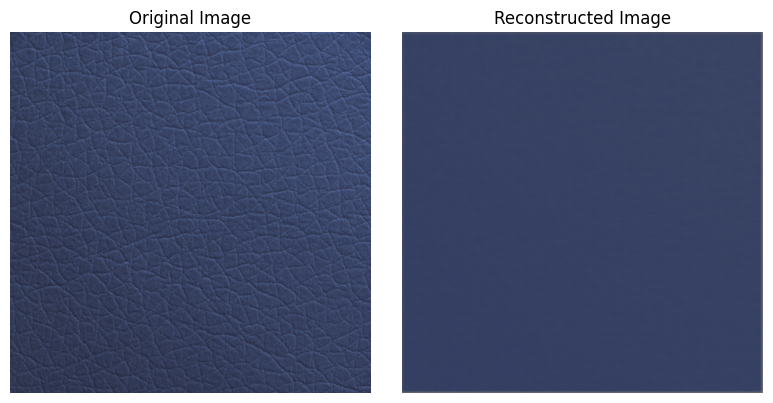

In [56]:
autoencoder_model.eval()

with torch.no_grad():
    for batch in train_loader:
        images, _ = batch
        reconstructed_images = autoencoder_model(images)

        #select first image
        original_image = np.transpose(images[0].cpu().numpy(), (1, 2, 0))
        reconstructed_image = np.transpose(reconstructed_images[0].cpu().numpy(), (1, 2, 0))

        # Visualize the original and reproduced images
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(reconstructed_image)
        plt.title('Reconstructed Image')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        break

### MSE 기반 threshold 찾기

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Set Autoencoder Model to Evaluation Mode
autoencoder_model.eval()

criterion = nn.MSELoss(reduction='none')

#Function that calculates the MSE value of an image data batch
def calculate_mse(images):
    outputs = autoencoder_model(images)
    mse = criterion(outputs, images).mean(dim=(1, 2, 3))
    return mse

normal_mse_values = []
abnormal_mse_values = []

all_labels=[]

# Save the MSE value
with torch.no_grad():
    for batch in test_normal_loader:
        images, labels = batch
        outputs = autoencoder_model(images)
        mse_values = calculate_mse(images)
        normal_mse_values.extend(mse_values.cpu().numpy())
        all_labels.extend(labels)

    for batch in test_anomaly_loader:
        images, labels = batch
        outputs = autoencoder_model(images)
        mse_values = calculate_mse(images)
        abnormal_mse_values.extend(mse_values.cpu().numpy())
        all_labels.extend(labels)

In [33]:
MSE=[]
MSE.extend(normal_mse_values)
MSE.extend(abnormal_mse_values)

#### 밀도함수 그래프

<ipython-input-27-9a403f2a033e>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(normal_mse_values, color='r', label='Normal Data', kde=False)
<ipython-input-27-9a403f2a033e>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(abnormal_mse_values, color='b', label='Abnormal Data', kde=False)


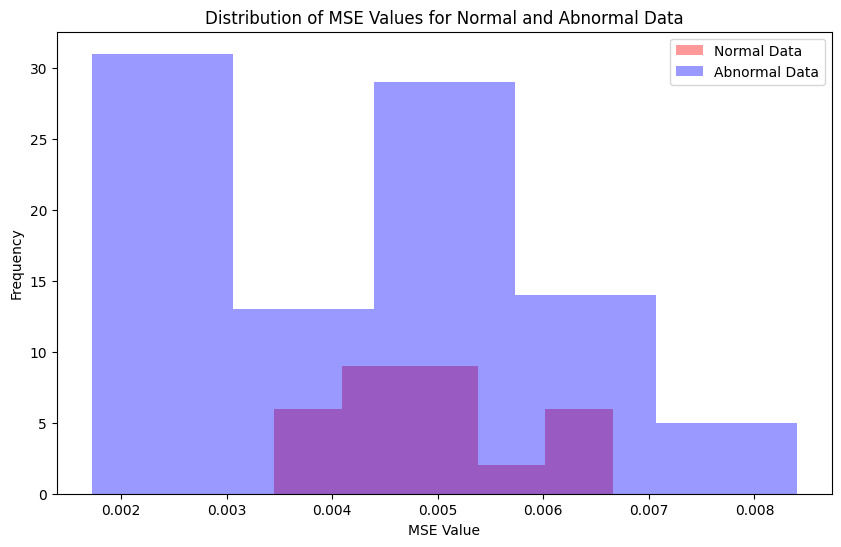

In [27]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.distplot(normal_mse_values, color='r', label='Normal Data', kde=False)
sns.distplot(abnormal_mse_values, color='b', label='Abnormal Data', kde=False)
plt.xlabel('MSE Value')
plt.ylabel('Frequency')
plt.title('Distribution of MSE Values for Normal and Abnormal Data')
plt.legend()
plt.show()

#### Z-score 그래프

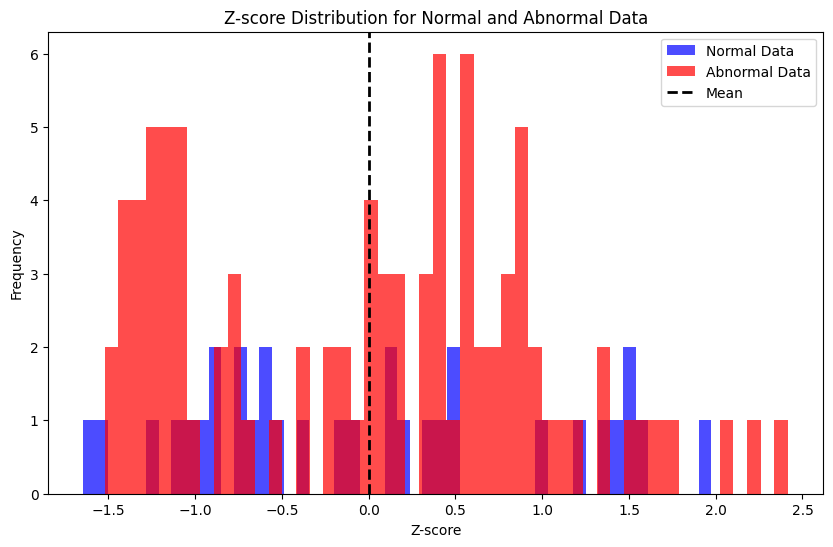

In [30]:
import numpy as np
import matplotlib.pyplot as plt


# Calculate mean and standard deviation
normal_mean = np.mean(normal_mse_values)
normal_std_dev = np.std(normal_mse_values)

abnormal_mean = np.mean(abnormal_mse_values)
abnormal_std_dev = np.std(abnormal_mse_values)

# Calculate Z-score
normal_z_scores = (normal_mse_values - normal_mean) / normal_std_dev
abnormal_z_scores = (abnormal_mse_values - abnormal_mean) / abnormal_std_dev

# Z-score graph
plt.figure(figsize=(10, 6))
plt.hist(normal_z_scores, bins=50, color='blue', alpha=0.7, label='Normal Data')
plt.hist(abnormal_z_scores, bins=50, color='red', alpha=0.7, label='Abnormal Data')
plt.axvline(x=0, color='black', linestyle='dashed', linewidth=2, label='Mean')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.title('Z-score Distribution for Normal and Abnormal Data')
plt.legend()
plt.show()


#### confusion matrix

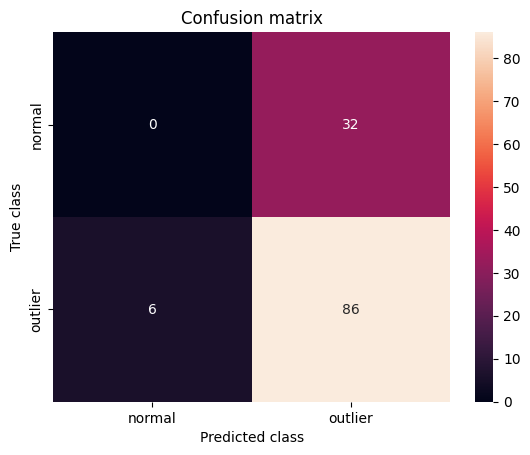

In [53]:
from sklearn.metrics import confusion_matrix
threshold= 0.002
y_pred = [1 if e > threshold else 0 for e in MSE]
conf_matrix = confusion_matrix(all_labels, y_pred)
plt.figure()
sns.heatmap(conf_matrix, xticklabels=["normal", "outlier"], yticklabels=["normal", "outlier"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()